<a href="https://colab.research.google.com/github/lverwimp/RNN_language_modeling/blob/master/rnn_lms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports:

In [1]:
import tensorflow as tf
import numpy as np
import urllib, collections, os
from rnn_lm import rnn_lm

ImportError: ignored

Some global variables:

In [0]:
BATCH_SIZE = 32
NUM_STEPS = 20

## Reading the data

Get training, validation and test data:

In [0]:
train_url = 'http://homes.esat.kuleuven.be/~lverwimp/course_speech_recognition/train.txt'
valid_url = 'http://homes.esat.kuleuven.be/~lverwimp/course_speech_recognition/valid.txt'
test_url = 'http://homes.esat.kuleuven.be/~lverwimp/course_speech_recognition/test.txt'
train_file = urllib.urlopen(train_url).read()
valid_file = urllib.urlopen(valid_url).read()
test_file = urllib.urlopen(test_url).read()

The data looks like this:

In [0]:
print('{0}...'.format(valid_file[:500]))

 consumers may want to move their telephones a little closer to the tv set 
 <unk> <unk> watching abc 's monday night football can now vote during <unk> for the greatest play in N years from among four or five <unk> <unk> 
 two weeks ago viewers of several nbc <unk> consumer segments started calling a N number for advice on various <unk> issues 
 and the new syndicated reality show hard copy records viewers ' opinions for possible airing on the next day 's show 
 interactive telephone technology...


<unk\> is a symbol for the unknown words class, 'N' is a symbol used for the numbers class.
  
Convert data to correct format:

In [0]:
# convert the string to a list and replace newlines with the end-of-sentence symbol
train_text = [w for w in train_file.replace('\n',' <eos>').split(' ')]
valid_text = [w for w in valid_file.replace('\n',' <eos>').split(' ')]
test_text = [w for w in test_file.replace('\n',' <eos>').split(' ')]

# count the frequencies of the words in the training data
counter = collections.Counter(train_text)

# sort according to decreasing frequency
count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

# words = list of all the words (in decreasing frequency)
items, _ = list(zip(*count_pairs))

# make a dictionary with a mapping from each word to an id; word with highest frequency gets lowest id etc.
item_to_id = dict(zip(items, range(len(items))))
id_to_item = dict(zip(range(len(items)), items))
vocab_size = len(item_to_id)

# convert the words to indices
train_ids_large = [item_to_id[item] for item in train_text]
valid_ids_large = [item_to_id[item] for item in valid_text]
test_ids_large = [item_to_id[item] for item in test_text]

# take a smaller subset to speed up training
train_ids = train_ids_large[:50000]
valid_ids = valid_ids_large[:10000]
test_ids = test_ids_large[:10000]

Once the data is converted to ids, it looks like this:

In [0]:
print(valid_ids[:100])

[2, 1133, 94, 359, 6, 330, 52, 9837, 7, 327, 2477, 6, 0, 663, 389, 2, 3, 1, 1, 2975, 2159, 10, 382, 1069, 2348, 90, 100, 848, 199, 1, 12, 0, 3384, 1120, 8, 4, 73, 21, 212, 347, 37, 259, 1, 1, 2, 3, 76, 423, 196, 3918, 5, 250, 1796, 1, 581, 3529, 893, 2375, 7, 4, 298, 12, 2710, 17, 1187, 1, 251, 2, 3, 9, 0, 36, 9923, 3748, 465, 711, 2999, 2038, 3918, 135, 6146, 12, 495, 5895, 17, 0, 131, 273, 10, 465, 2, 3, 9959, 733, 504, 31, 642, 7, 36, 6499]


## Code for building, training and testing neural language models

Class for the language model:

In [0]:
class rnn_lm(object):
  '''
  This is a class to build and execute a recurrent neural network language model.
  '''
  
  def __init__(self,
              cell='LSTM',
              optimizer='SGD',
              lr=1,
              vocab_size=10000,
              embedding_size=64,
              hidden_size=128,
              dropout_rate=0.5,
              batch_size=BATCH_SIZE,
              num_steps = NUM_STEPS,
              is_training=True):
    # hyperparameters that can be changed
    self.which_cell = cell
    self.which_optimizer = optimizer
    self.vocab_size = vocab_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.dropout_rate = dropout_rate
    self.is_training = is_training
    self.lr = lr
    self.batch_size = batch_size
    self.num_steps = num_steps
    
    # hard-coded hyperparameters
    self.max_grad_norm = 5
    
    
    self.init_graph()
    
    self.output, self.state = self.feed_to_network()
    
    self.loss = self.calc_loss(self.output)
    
    if self.is_training:
      self.update_params(self.loss)
    
    
  def init_graph(self):
    '''
    This function initializes all elements of the network.
    '''
    
    self.inputs = tf.placeholder(dtype=tf.int32, shape=[self.batch_size, self.num_steps])
    self.targets = tf.placeholder(dtype=tf.int32, shape=[self.batch_size, self.num_steps])
    
    # input embedding weights
    self.embedding = tf.get_variable("embedding", 
                                     [self.vocab_size, self.embedding_size], 
                                     dtype=tf.float32)
    
    # hidden layer
    if self.which_cell == 'LSTM':
      self.basic_cell = tf.contrib.rnn.LSTMCell(self.hidden_size)
    elif self.which_cell == 'RNN':
      self.basic_cell = tf.contrib.rnn.BasicRNNCell(self.hidden_size)
    else:
      raise ValueError("Specify which type of RNN you want to use: RNN or LSTM.")
      
    # apply dropout  
    self.cell = tf.contrib.rnn.DropoutWrapper(self.basic_cell, 
                                              output_keep_prob=self.dropout_rate)
    
    # initial state contains all zeros
    self.initial_state = self.cell.zero_state(self.batch_size, tf.float32)
    
    # output weight matrix and bias
    self.softmax_w = tf.get_variable("softmax_w",
                                     [self.hidden_size, self.vocab_size], 
                                     dtype=tf.float32)
    self.softmax_b = tf.get_variable("softmax_b",
                                     [self.vocab_size], 
                                     dtype=tf.float32)
    
    self.initial_state = self.cell.zero_state(self.batch_size, dtype=tf.float32)
    
    
  def feed_to_network(self):
    '''
    This function feeds the input to the network and returns the output and the state.
   
    '''
    
    # map input indices to continuous input vectors
    inputs = tf.nn.embedding_lookup(self.embedding, self.inputs)

	  # use dropout on the input embeddings
    inputs = tf.nn.dropout(inputs, self.dropout_rate)
    
    state = self.initial_state
    
    # feed inputs to network: outputs = predictions, state = new hidden state
    outputs, state = tf.nn.dynamic_rnn(self.cell, inputs, sequence_length=None, initial_state=state)
    
    output = tf.reshape(tf.concat(outputs, 1), [-1, self.hidden_size])
    
    return output, state
    
  
  def calc_loss(self, output):
    
    # calculate logits
    # shape of logits = [batch_size*num_steps, vocab_size]
    logits = tf.matmul(output, self.softmax_w) + self.softmax_b
    
    self.softmax = tf.nn.softmax(logits)
      
    # calculate cross entropy loss
    # reshape targets such that it has shape [batch_size*num_steps]
    # loss: contains loss for every time step in every batch
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=tf.reshape(self.targets, [-1]), logits=logits)
      
    # average loss per batch
    avg_loss = tf.reduce_sum(loss) / self.batch_size
    
    return avg_loss
  
  def update_params(self, loss):
    
    # calculate gradients for all trainable variables 
    # + clip them if their global norm > 5 (prevents exploding gradients)
    grads, _ = tf.clip_by_global_norm(
        tf.gradients(loss, tf.trainable_variables()), self.max_grad_norm)
    
    if self.which_optimizer == 'SGD':
      optimizer = tf.train.GradientDescentOptimizer(self.lr)
    elif self.which_optimizer == 'Adam':
      optimizer = tf.train.AdamOptimizer(self.lr)
    else:
      raise ValueError("Specify which type of optimizer you want to use: SGD or Adam.")
    
    # update the weights
    self.train_op = optimizer.apply_gradients(
				zip(grads, tf.trainable_variables()))

Create a class that will generate mini-batches from the data.

In [0]:
class batchGenerator(object):
  '''
  This class generates batches for a dataset.
  Input argument:
    data: list of indices (word ids)
  '''
  
  def __init__(self, data, test=False):
    '''
    Prepares a dataset.
    '''
  
    self.test = test 

    self.data_array = np.array(data)
  
    if not self.test:
      len_batch_instance = len(data) / BATCH_SIZE

      data_array = self.data_array[:BATCH_SIZE*len_batch_instance]

      # divide data in BATCH_SIZE parts
      self.data_reshaped = np.reshape(data_array, (BATCH_SIZE, len_batch_instance))

      # number of mini-batches that can be generated
      self.num_batches_in_data = len_batch_instance / NUM_STEPS - 1
    
    self.curr_idx = 0
  
  def generate(self):
    '''
    Generates
      input_batch: numpy array or None, if the end of the dataset is reached
      target_batch: numpy array or None, if the end of the dataset is reached
      end_reached: boolean, True is end of dataset is reached
    '''
    
    if self.test:
      if self.curr_idx+1 >= len(self.data_array):
        return None, None, True
      
      input_batch = [[self.data_array[self.curr_idx]]]
      target_batch = [[self.data_array[self.curr_idx+1]]]
      
    else:
      if self.curr_idx >= self.num_batches_in_data:
        return None, None, True

      # input: take slice of size BATCH_
      input_batch = self.data_reshaped[:,self.curr_idx*BATCH_SIZE:self.curr_idx*BATCH_SIZE+BATCH_SIZE]

      # target = input shifted 1 time step
      target_batch = self.data_reshaped[:,self.curr_idx*BATCH_SIZE+1:self.curr_idx*BATCH_SIZE+BATCH_SIZE+1]    

    self.curr_idx += 1
    
    return input_batch, target_batch, False
  


Here is an example of how batchGenerator can be used. You will notice that the target batch contains the same indices as the input batch, but shifted one (time) step to the right.

In [0]:
generator = batchGenerator(valid_ids)
input_batch, target_batch, end_reached = generator.generate()
print('This is what an input batch looks like:\n{0}'.format(input_batch))
print('And this is what a target batch looks like:\n{0}'.format(target_batch))

This is what an input batch looks like:
[[   2 1133   94  359    6  330   52 9837    7  327 2477    6    0  663
   389    2    3    1    1 2975]
 [  30   15   10 1540    6   26   44    4    4  626 2039    1  173    2
     3   65   47  584    6  189]
 [   1   95 2469   11  390    1   47  214 9936   20    1   80   26 1950
    67    0    1    5    1  175]
 [ 146 2370   16    2    3  640  748 3382 4740 2785   57  336  562    8
  1120   23    7   13    4   49]
 [  47 3280   11   24 2785   37   55    5    0   62 1379 1557  280    1
    23    0  948    8 6393   37]
 [  15  176   33 1056    6  330  122 1296   28    1 1853    8  133 8666
  9744    2    3   68   24 2670]
 [1094  485    1 3218   94   26  659    6  621   11 1030   30 1371   37
  6552 8336  128   20   39    1]
 [   2    3   36  632 4168   83 3089   96 3254 2369    0  695  904   12
    28  463    5 1768    1    1]
 [ 607  363    2    3    1 2848   10    1 3404  193    7 5443    2    3
   190    1   35    6   26   75]
 [   6  300   3

This is a function that does one pass over the whole dataset. If we are training the model, it will update the parameters and return the perplexity. Otherwise, it will just return the perplexity.

In [0]:
def run_epoch(session, rnn, data, is_training=True, is_test=False, test_log_prob=False):
    '''
    This function runs a single epoch (pass) over the data,
    updating the model parameters if we are training,
    and returns the perplexity.
    Input arguments:
      rnn: object of the rnn_lm class
      data: list of word indices
      is_training: boolean, True is we are training the model
      is_test: boolean, True is we are testing a trained model
    Returns:
      ppl: float, perplexity of the dataset
    '''
  
    generator = batchGenerator(data, test=is_test)
      
    state = session.run(rnn.initial_state)
    sum_loss = 0.0
    iters = 0
    
    if test_log_prob: 
      sum_log_prob = 0.0
      
    while True:

      input_batch, target_batch, end_reached = generator.generate()
        
      if end_reached:
        break

      feed_dict = {rnn.inputs: input_batch,
                  rnn.targets: target_batch,
                  rnn.initial_state : state}

      fetches = {'loss': rnn.loss,
                'state': rnn.state}
      
      if is_training:
        fetches['train_op'] = rnn.train_op
        
      if test_log_prob:
        fetches['softmax'] = rnn.softmax
        
      result = session.run(fetches, feed_dict)
        
      state = result['state']
      loss = result['loss']
      
      if test_log_prob:
        softmax = result['softmax']
        prob_target = softmax[0][target_batch[0][0]]
        sum_log_prob += np.log(prob_target)

      sum_loss += loss
      # the loss is an average over num_steps
      if is_test:
        iters += 1
      else:
        iters += NUM_STEPS
        
    # calculate perplexity    
    ppl = np.exp(sum_loss / iters)
    
    if test_log_prob:
      print('Log probability: {0}'.format(sum_log_prob))
    
    return ppl

This function can be called to build, train and test models with different parameter settings. 

In [0]:
def run_lm(cell='LSTM', optimizer='SGD', lr=1, 
           embedding_size=64, hidden_size=128, 
           dropout_rate=0.5, inspect_emb=False,
           train_ids=None, valid_ids=None, test_ids=None,
           test_log_prob=False):
  '''
  Creates training, validation and/or test models,
  trains, validates and/or tests the model.
  '''
    
  with tf.Graph().as_default() as graph:

      # create the models
      if not test_log_prob:
      
        with tf.variable_scope("Model"):
          rnn_train = rnn_lm(cell=cell,
                             optimizer=optimizer, 
                             lr=lr,
                             vocab_size=vocab_size,
                             embedding_size=embedding_size,
                             hidden_size=hidden_size,
                             dropout_rate=dropout_rate)

          saver = tf.train.Saver()

        with tf.variable_scope("Model", reuse=True):
          rnn_valid = rnn_lm(cell=cell, 
                             optimizer=optimizer,
                             lr=lr,
                             vocab_size=vocab_size, 
                             embedding_size=embedding_size,
                             hidden_size=hidden_size,
                             dropout_rate=dropout_rate,
                             is_training=False)
          
        reuse = True
        
      else:
        reuse = False
               
      with tf.variable_scope("Model", reuse=reuse):
        rnn_test = rnn_lm(cell=cell, 
                           optimizer=optimizer, 
                           lr=lr,
                           vocab_size=vocab_size,
                           embedding_size=embedding_size,
                           hidden_size=hidden_size,
                           dropout_rate=dropout_rate,
                           batch_size=1,
                           num_steps=1,
                           is_training=False)
      

      sv = tf.train.Supervisor(logdir='models')

      with sv.managed_session(config=tf.ConfigProto()) as session:
        
        if not test_log_prob:
        
          for i in xrange(5):

            print('Epoch {0}'.format(i+1))

            train_ppl = run_epoch(session, rnn_train, train_ids)
            print('Train perplexity: {0}'.format(train_ppl))

            valid_ppl = run_epoch(session, rnn_valid, valid_ids, is_training=False)
            print('Validation perplexity: {0}'.format(valid_ppl))

          save_path = saver.save(session, "models/rnn.ckpt")
          print('Saved the model to ',save_path)

        test_ppl = run_epoch(session, rnn_test, test_ids, 
                             is_training=False, is_test=True, 
                             test_log_prob=test_log_prob)
        if not test_log_prob:
          print('Test perplexity: {0}'.format(test_ppl))
        
        if inspect_emb: 
          emb_matrix = tf.get_default_graph().get_tensor_by_name("Model/embedding:0")
          emb_matrix_np = emb_matrix.eval(session=session)

          return emb_matrix_np

        else:

          return None
      

## Training networks

Training neural networks requires a lot of hyperparameter tuning. The hyperparameters of a neural network are for example the type of cell, its size, the method that is used for updating its parameters (also called 'optimizer' ), the type and strength of regularization, ... . All these hyperparameters have to be chosen before the network can built, trained and tested, and they all have to some extent an influence on the  performance of the model.

Recurrent neural networks are neural networks that take as input a combination of the standard input and the hidden state of the previous time step. Let's first train a simple recurrent neural network (RNN) as a language model. 

### Optimizer

Let's now train a simple RNN as language model.

In [0]:
run_lm(cell='RNN')

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
Epoch 1
train_ppl: 28579.2624974
valid_ppl: 7976.3365824
Epoch 2
train_ppl: 10458.1135736
valid_ppl: 1364.88939657
Epoch 3
train_ppl: 1536.37432389
valid_ppl: 2130.04265576
Epoch 4
train_ppl: 870.760132806
valid_ppl: 709.111377606
Epoch 5
train_ppl: 713.030860672
valid_ppl: 724.993998427
test_ppl: 689.391726604


You see that both the training perplexity and the validation perplexity decreased during training, which is a good sign. However, notice that the validation perplexity of epoch 5 is slightly higher than the validation perplexity of epoch 4. 


In [0]:
run_lm(cell='RNN', optimizer='Adam')

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
Epoch 1
train_ppl: 8.3480932363e+189
valid_ppl: 8.94273109753e+240
Epoch 2
train_ppl: 8.90212615289e+269
valid_ppl: 2.70133700595e+271
Epoch 3


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in exp


train_ppl: inf
valid_ppl: inf
Epoch 4
train_ppl: inf
valid_ppl: inf
Epoch 5
train_ppl: inf
valid_ppl: inf
test_ppl: inf


### Learning rate

Judging from the perplexities above, it seems like the Adam optimizer is a bad choice for training our network! However, the interplay between the different hyperparameters of a neural network is complicated, and it is very well possible that a specific optimizer needs a different learning rate. 
Let's try a learning rate of 0.01 instead of 1:

In [0]:
run_lm(cell='RNN', optimizer='Adam', lr=0.01)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
Epoch 1
train_ppl: 1057.75617242
valid_ppl: 958.832506035
Epoch 2
train_ppl: 564.324279113
valid_ppl: 826.433342462
Epoch 3
train_ppl: 433.956799222
valid_ppl: 793.489183177
Epoch 4
train_ppl: 364.952622399
valid_ppl: 723.403317321
Epoch 5
train_ppl: 324.387741371
valid_ppl: 699.624224383
test_ppl: 532.177735851


This time, the network is converging nicely. Maybe reducing the learning rate even further helps? Let's try a learning rate of 0.001:

In [0]:
run_lm(cell='RNN', optimizer='Adam', lr=0.001)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
Epoch 1
train_ppl: 647.90650982
valid_ppl: 490.249928851
Epoch 2
train_ppl: 378.543344185
valid_ppl: 413.048300797
Epoch 3
train_ppl: 300.501997416
valid_ppl: 375.886351108
Epoch 4
train_ppl: 258.467386044
valid_ppl: 367.867747945
Epoch 5
train_ppl: 232.486608834
valid_ppl: 356.596671902
test_ppl: 286.110701589


We see an additional improvement. Let's see what reducing the learning rate even further, to 0.0001, gives:

In [0]:
run_lm(cell='RNN', optimizer='Adam', lr=0.0001)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
Epoch 1
train_ppl: 1366.65057312
valid_ppl: 677.639747264
Epoch 2
train_ppl: 630.575866312
valid_ppl: 690.140848653
Epoch 3
train_ppl: 625.483174618
valid_ppl: 707.694743583
Epoch 4
train_ppl: 620.683702468
valid_ppl: 1629.80400103
Epoch 5
train_ppl: 668.006540818
valid_ppl: 1913.05069198
test_ppl: 1789.96267687


Here we see an interesting result: the training perplexity decreased between epoch 0 and 4, but the validation perplexity is continuously increasing. For epoch 5, even the training perplexity increased again. This is an example of a learning rate that is too small: the steps that the network is making are too small.

### Type of RNN cell

A simple RNN has some disadvantages: it often suffers from the so-called *vanishing and exploding gradients* problem. Neural networks are trained with an algorithm called backpropagation, which computes the gradients of the loss with respect to all parameters in the network. For a language model, the loss of the network is called the *cross entropy*, and it is equal to the average negative log probability for every word in the data. The perplexity of the language model is simply the exponential of the cross entropy. In the case of the simple RNN shown above, the parameters would be the weight matrices $\mathbf{W}$, $\mathbf{U}$ and $\mathbf{V}$ and the bias vectors $\mathbf{b}$ and $\mathbf{b_v}$. The gradients of the loss with respect to the parameters $\mathbf{V}$ and $\mathbf{b_v}$ can be calculated directly, but the gradients with respect to the other parameters in the network are calculated based on the chain rule, which results in multiplying many terms. Moreover, an RNN is typically *unrolled in time*, which means that you also want to update the weights for the words seen before. If the terms in the multiplication are very small or very  large, they can quickly get even smaller (vanish) or larger (explode). The exploding gradients problem can relatively easily be solved by clipping the (norm of) the gradients if they become too large, the vanishing gradients problem is (at least partially) solved by using another type of RNN cell, such as a long short-term memory (LSTM) cell.

An LSTM contains two hidden states instead of one, a cell state $\mathbf{c}_t$ and a hidden state $\mathbf{h}_t$, and  three gates, the input gate, forget gate and output gate. The gates are shown in the upper part of the figure below: they have a sigmoid activation function, which makes sure that the output values are all between 0 and 1. The forget gate $\mathbf{f}_t$ is combined with the cell state $\mathbf{c}_t$: it thus decides which parts of the previous cell state should be forgetten (values close to 0) and which not (values close to 1). A new cell state is then calculated based on a combination of the input gate $\mathbf{i}_t$, which decides what should be added, and the candidate values $\mathbf{p}_t$, which are the result of a $tanh$ non-linearity. The new cell state $\mathbf{c}_t$ is then put through another $tanh$, and combined with the output gate, which decides which part of the input should be let through to the new hidden state $\mathbf{h}_t$. The last part of the network is the equal to the simple RNN. This [blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) gives a great description of how an LSTM cell works.

![alt text](https://github.com/lverwimp/RNN_language_modeling/blob/master/LSTM.png?raw=1)

We take the optimal combination of optimizer (Adam) and learning rate (0.001) for an RNN, and use it to train an LSTM:

In [0]:
run_lm(cell='LSTM', optimizer='Adam', lr=0.001)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
Epoch 1
train_ppl: 656.82063114
valid_ppl: 529.864473663
Epoch 2
train_ppl: 424.844078727
valid_ppl: 464.263171504
Epoch 3
train_ppl: 356.302922604
valid_ppl: 419.632020537
Epoch 4
train_ppl: 312.305264384
valid_ppl: 397.430353409
Epoch 5
train_ppl: 279.950894164
valid_ppl: 376.370915052
test_ppl: 308.514639823


Surprise! The LSTM gives a worse test perplexity, 308.5, than the RNN with the same hyperparameters, 286.1. Looking at the evolution of the perplexities over epochs, we see that they only slowly decrease. Maybe we need a larger learning rate for an LSTM?

In [0]:
run_lm(cell='LSTM', optimizer='Adam', lr=0.01, inspect_emb=True)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
Epoch 1
train_ppl: 481.709334113
valid_ppl: 396.625967937
Epoch 2
train_ppl: 286.597902762
valid_ppl: 355.204807228
Epoch 3
train_ppl: 235.102307065
valid_ppl: 341.794086337
Epoch 4
train_ppl: 207.242568642
valid_ppl: 341.275447747
Epoch 5
train_ppl: 188.696659696
valid_ppl: 349.23735006
test_ppl: 264.915329849


TypeError: ignored

This perplexity is already much better. By further optimizing of the learning rate and/or optimizer, we could probably get even lower perplexities.

### Size of the embedding

Let's now take a look at the influence of the size of the LSTM on its performance. By default, we train a model with embeddings of size 64 and a hidden layer of size 128. Let's see what happens if we reduce the size of the embedding:

In [0]:
run_lm(cell='LSTM', optimizer='Adam', lr=0.01, embedding_size=16)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
Epoch 1
train_ppl: 519.359682418
valid_ppl: 5124521.52183
Epoch 2
train_ppl: 325.127520433
valid_ppl: 384.575596662
Epoch 3
train_ppl: 273.853564489
valid_ppl: 366.642785843
Epoch 4
train_ppl: 245.163913857
valid_ppl: 358.26870915
Epoch 5
train_ppl: 225.340377224
valid_ppl: 356.266744414
test_ppl: 288.184551098


### Size of the hidden layer

In [0]:
run_lm(cell='LSTM', optimizer='Adam', lr=0.01, hidden_size=64)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
Epoch 1
train_ppl: 522.602473469
valid_ppl: 433.018669464
Epoch 2
train_ppl: 325.534562413
valid_ppl: 382.469223656
Epoch 3
train_ppl: 271.586685795
valid_ppl: 365.897337815
Epoch 4
train_ppl: 241.188401725
valid_ppl: 356.627466171
Epoch 5
train_ppl: 221.587265914
valid_ppl: 352.766427407
test_ppl: 279.318501236


### Regularization

In [0]:
run_lm(cell='LSTM', optimizer='Adam', lr=0.01, dropout_rate=0.1)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
Epoch 1
train_ppl: 809.953863498
valid_ppl: 658.909363669
Epoch 2
train_ppl: 584.828653476
valid_ppl: 606.689601129
Epoch 3
train_ppl: 539.409788271
valid_ppl: 585.649933925
Epoch 4
train_ppl: 519.498692319
valid_ppl: 574.898769121
Epoch 5
train_ppl: 508.607510944
valid_ppl: 574.182146616
test_ppl: 517.1558548


## Testing

Let's now test a trained network by calculating the log probability for a sentence. To do this, we first convert the sentence to indices and then run the model:

In [0]:
def get_log_prob(cell='LSTM', optimizer='SGD', lr=1, 
           embedding_size=64, hidden_size=128, 
           dropout_rate=0.5, train_ids=None,
           valid_ids=None, test_sent=None):
  
  # convert words to indices
  test_idx = []
  for w in test_sent.split(' '):
    if w not in item_to_id:
      raise IOError("{0} is not part of the vocabulary".format(w))
    else:
      test_idx.append(item_to_id[w])

  run_lm(cell=cell, 
         optimizer=optimizer, 
         lr=lr,
         embedding_size=embedding_size,
         hidden_size=hidden_size,
         dropout_rate=dropout_rate,
         inspect_emb=False, 
         train_ids=train_ids, 
         valid_ids=valid_ids, 
         test_ids=test_idx,
         test_log_prob=True)

      


To get the log probability of a specific sentence, use the following commands:

In [0]:
get_log_prob(test_sent='this is a test')
get_log_prob(test_sent='test a a a')

INFO:tensorflow:Restoring parameters from models/model.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:Saving checkpoint to path models/model.ckpt
Log probability: -15.9990825653
INFO:tensorflow:Restoring parameters from models/model.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path models/model.ckpt
INFO:tensorflow:Starting queue runners.
Log probability: -24.7472014427


You should see that the log probability of 'test a a a' is lower than 'this is a test', which makes sense. You can test your own sentences here:

In [0]:
# get_log_prob('your own test sentence')

## Word embeddings

Often the input words for a language model are represented as indices in a vocabulary, or one-hot vectors (where all values are 0 except the index of the word, which has value 1). This representation is a discrete representation, just like in n-gram language models. It has the disadvantage that relationships between words (e.g. the syntactic relationship between 'eat' and 'eating', or the semantic relationship between 'eat' and 'drink') can not be inferred from the word representations. 

Neural language models however, do not use this representation as is but first map it to a continuous, lower-dimensional vector, also called *word embedding*. They do this by looking up the index of the word in a weight matrix $\mathbf{W}$, which is often called the embedding matrix. By training the embedding matrix jointly with the rest of the language model, the resulting word embeddings will have some interesting properties: several syntactic and semantic relationships are encoded as vector offsets in the embedding space. A famous example is the vector offset for male - female, which is shown in the example below:

![alt text](https://github.com/lverwimp/RNN_language_modeling/blob/master/kingqueen.png?raw=1)

Let's now train a language model and return the embedding matrix of the trained model:

In [0]:
emb_matrix = run_lm(cell='LSTM', 
                    optimizer='Adam', 
                    lr=0.01, 
                    inspect_emb=True, 
                    train_ids=train_ids, 
                    valid_ids=valid_ids, 
                    test_ids=test_ids)

INFO:tensorflow:Restoring parameters from models/rnn.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path models/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 1
Train perplexity: 205.207137658
Validation perplexity: 719.099237175
Epoch 2
Train perplexity: 183.706281768
Validation perplexity: 754.872969176
Epoch 3
Train perplexity: 166.842466179
Validation perplexity: 758.458571841
Epoch 4
Train perplexity: 152.107296048
Validation perplexity: 790.319179867
Epoch 5
Train perplexity: 139.465680327
Validation perplexity: 839.929676526
('Saved the model to ', 'models/rnn.ckpt')
Test perplexity: 624.673774295


In [0]:
def find_closest_words(emb_matrix, word):
  if word not in item_to_id:
    raise IOError('This item is not in the vocabulary')
    
  else:
    id_w = item_to_id[word]
    emb_w = emb_matrix[id_w]
    norm_emb_w = emb_w / np.linalg.norm(emb_w)
    
    top_10 = {}
    
    # iterate over all words
    for idx in range(emb_matrix.shape[0]):
      # ignore the word itself
      if idx != id_w:
        
        norm_curr_w = emb_matrix[idx] / np.linalg.norm(emb_matrix[idx])
        
        cos_sim = np.dot(norm_emb_w, norm_curr_w)
        
        #cos_sim = np.dot(emb_w, emb_matrix[idx]) / \
        #   norm_emb_w * np.linalg.norm(emb_matrix[idx])
        
        #print('{0}\t{1}'.format(id_to_item[idx], cos_sim))
        
        # keep list of top 10 largest cos similarities
        if len(top_10) >= 10:
          for sim in top_10.iterkeys():
            if cos_sim > sim:
              
              #print(cos_sim)
              #print('add new')
              #print(top_10)
              
              del top_10[sim]
              top_10[cos_sim] = id_to_item[idx]
              break
        
        else:
          top_10[cos_sim] = id_to_item[idx]
          
        
    print('Words with largest cosine similarity w.r.t. {0}'.format(word))
    print('Word\t\tCosine similarity')
    # sort the top 10 
    for sim in sorted(top_10, key=float):
      print('{0}\t\t{1}'.format(top_10[sim], sim))
      
     
    
 
    
    

In [0]:
find_closest_words(emb_matrix, 'test')
find_closest_words(emb_matrix, 'cat')

#large_emb_f = 'http://homes.esat.kuleuven.be/~lverwimp/course_speech_recognition/emb_matrix.npy'
#large_emb_matrix = np.load(urllib.urlopen(large_emb_f))


Words with largest cosine similarity w.r.t. test
Word		Cosine similarity
widespread		0.41984885931
measurement		0.436767011881
philippines		0.44938313961
cameras		0.466574847698
creativity		0.468799412251
upset		0.481771558523
disagreement		0.486380904913
widow		0.487539678812
sets		0.512381672859
fight		0.520383238792
Words with largest cosine similarity w.r.t. cat
Word		Cosine similarity
high-technology		0.405961900949
calculated		0.410305857658
quebecor		0.422998338938
o'brien		0.433450311422
arena		0.441936612129
comparison		0.44216132164
sheets		0.443423748016
textile		0.453138113022
anyone		0.466919213533
giant		0.520065248013


In [0]:
emb_matrix_large = run_lm(cell='LSTM', optimizer='Adam', lr=0.01, inspect_emb=True, large_data=True)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
Epoch 1
Train perplexity: 297.18710552
Validation perplexity: 234.21438526
Epoch 2
Train perplexity: 204.754365857
Validation perplexity: 213.141694848
Epoch 3
Train perplexity: 184.758054706
Validation perplexity: 204.33167339
Epoch 4
Train perplexity: 174.919933556
Validation perplexity: 200.768920798
Epoch 5
Train perplexity: 168.839457556
Validation perplexity: 199.088644593
('Saved the model to ', 'models/rnn.ckpt')
Test perplexity: 186.386608675


In [0]:
np.save('emb_matrix_large.npy', emb_matrix_large)

find_closest_words(emb_matrix_large, 'test')
find_closest_words(emb_matrix_large, 'cat')


Words with largest cosine similarity w.r.t. test
Word		Cosine similarity
image		0.465192139149
sense		0.475327432156
breath		0.482072114944
leaks		0.493268549442
installation		0.493875324726
quality		0.494197249413
drill		0.502717137337
booklets		0.527451217175
establishment		0.554006934166
church		0.633638620377
Words with largest cosine similarity w.r.t. cat
Word		Cosine similarity
engines		0.469503223896
sedan		0.469615578651
viewers		0.469927728176
caribbean		0.470124840736
ports		0.471759349108
finkelstein		0.475126177073
fashion		0.475862652063
alcohol		0.487063854933
psychological		0.505108237267
aircraft		0.535113990307


[[ 1.2317762  -0.28708664]
 [ 0.44513637  0.10185511]
 [-4.613992    6.734643  ]
 ...
 [ 0.8617239   0.5311671 ]
 [ 2.5116565  -0.19842397]
 [-0.7011888  -1.1982691 ]]
(10001,)


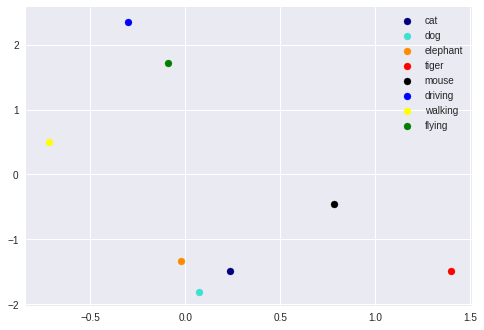

In [0]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(emb_matrix_large)
print(principalComponents)
print(principalComponents[:,0].shape)

colors = ['navy', 'turquoise', 'darkorange', 'red', 'black', 'blue','yellow','green']
target_names = ['cat', 'dog', 'elephant', 'tiger', 'mouse', 'driving','walking','flying']

for color, target_name in zip(colors, target_names):
    plt.scatter(principalComponents[item_to_id[target_name], 0], 
                principalComponents[item_to_id[target_name], 1], 
                color=color, 
                label=target_name)
plt.legend()
